## Project: Thermodynamical Properties

In [1]:
# !pip install mpi4py
# !pip install numba

### Import Library

In [2]:
import numpy as np
import sympy as sp
#import cupy as cp
#from numba import int32, int64, float32, float64, vectorize

import os
from mpi4py import MPI
from numba import njit

import matplotlib.pyplot as plt
from plotly import graph_objs as go
from plotly import express as px
from IPython.display import Image

import time
import timeit
from threading import Thread
from multiprocessing import Pool, Process
from scipy.integrate import quad

import pickle
import warnings
warnings.filterwarnings('ignore')

### Import data

In [39]:
with open("saved_data/enthropy_time.pkl", "rb") as file:
    enthropy_time = pickle.load(file)

with open("saved_data/enthalpy_time.pkl", "rb") as file:
    enthalpy_time = pickle.load(file)

with open("saved_data/paral_enthalpy_time.pkl", "rb") as file:
    paral_enthalpy_time = pickle.load(file)

with open("saved_data/gibbsEnergy_time.pkl", "rb") as file:
    gibbsEnergy_time = pickle.load(file)

with open("saved_data/paral_gibbsEnergy_time.pkl", "rb") as file:
    paral_gibbsEnergy_time = pickle.load(file)

with open("saved_data/helmEnergy_time.pkl", "rb") as file:
    helmEnergy_time = pickle.load(file)

with open("saved_data/paral_helmEnergy_time.pkl", "rb") as file:
    paral_helmEnergy_time = pickle.load(file)

with open("saved_data/gpu_speed_calc.pkl", "rb") as file:
    gpu_speed_calc = pickle.load(file)


### Functions

In [46]:
%%writefile saved_files/custom_function.py
import numpy as np
from numba import njit

def trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)

    for x in np.linspace(xmin, xmax, n):
        integral += dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2

    return integral

def func(x):
    return (1 - x**2)**0.5

def phonon_dos(omega, omega_c=10, C=1):
    return C * omega**2 * np.exp(-omega / omega_c)

def entropy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * phonon_dos(omega)

@njit
def jit_entropy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * 1 * omega**2 * np.exp(-omega / 10)

def phonon_dos(omega, omega_c=10, C=1):
    return C * omega**2 * np.exp(-omega / omega_c)

def enthalpy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return hbar*omega * (1 / np.tanh(x / 2)) * phonon_dos(omega)

@njit
def jit_enthalpy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return hbar*omega * (1 / np.tanh(x / 2)) * 1 * omega**2 * np.exp(-omega / 10)

def cpu_trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)
    x = np.linspace(xmin, xmax, n)
    integral = dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2
    return integral.sum()

def helmholtz_energy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return np.log(2 * np.sinh(x / 2)) * 1 * omega**2 * np.exp(-omega / 10)

Overwriting saved_files/custom_function.py


In [44]:
import saved_files.custom_function as custom_f

### Constants

In [40]:
hbar = 1.054e-34
kB = 1.38e-23
custom_f.trapezoidal_function(
    f=custom_f.func,
    xmin=-0.99,
    xmax=0.99,
    n=10000,
)

1.5686275328175605

### Task 1: Enthropy | Multiprocessing

![](Project_images/Entropy_equation.png)

#### Values

In [41]:
omega_min, omega_max = 1, 1000
n = 2000000
T=273

In [45]:
entropy_value = kB * custom_f.trapezoidal_function(
    f=custom_f.entropy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar)
entropy_value

8.273599920779007e-19

#### Functions

In [43]:
def par_trapezoidal_function(params):
    f, xmin, xmax, n, T, kB, hbar = params
    integral = 0.0
    dx = (xmax - xmin) / (n+1)

    for x in np.linspace(xmin, xmax, n):
        integral += dx * ( f(x, T, kB, hbar) + f(x+dx, T, kB, hbar) )/2

    return integral

#### Implementation

In [46]:
num_intervals = 2
chunk_size = omega_max / num_intervals
intervals = []
for i in range(num_intervals):
  if i == 0:
    intervals.append((custom_f.entropy, i * chunk_size+1, (i + 1) * chunk_size, n//num_intervals, T, kB, hbar))
  else:
    intervals.append((custom_f.entropy, i * chunk_size, (i + 1) * chunk_size, n//num_intervals, T, kB, hbar))

with Pool(processes=num_intervals) as pool:
    results = pool.map(func=par_trapezoidal_function, iterable=intervals)

kB*sum(results)

8.273591647184507e-19

#### Performance

In [38]:
num_procs = np.zeros(7, dtype=np.int16)
num_procs[0] = int(1)
num_procs[1:] = np.arange(2, 13, 2)

In [47]:
enthropy_time = np.zeros(len(num_procs))
for j, procs in enumerate(num_procs):
    num_intervals = procs
    chunk_size = omega_max / num_intervals
    intervals = []
    for i in range(num_intervals):
      if i == 0:
        intervals.append((custom_f.entropy, i * chunk_size+1, (i + 1) * chunk_size, n//num_intervals, T, kB, hbar))
      else:
        intervals.append((custom_f.entropy, i * chunk_size, (i + 1) * chunk_size, n//num_intervals, T, kB, hbar))
    start_time = time.time()
    with Pool(processes=num_intervals) as pool:
        pool.map(func=par_trapezoidal_function, iterable=intervals)
    end_time = time.time()
    enthropy_time[j] = end_time - start_time

with open("saved_data/enthropy_time.pkl", "wb") as file:
    pickle.dump(enthropy_time, file)

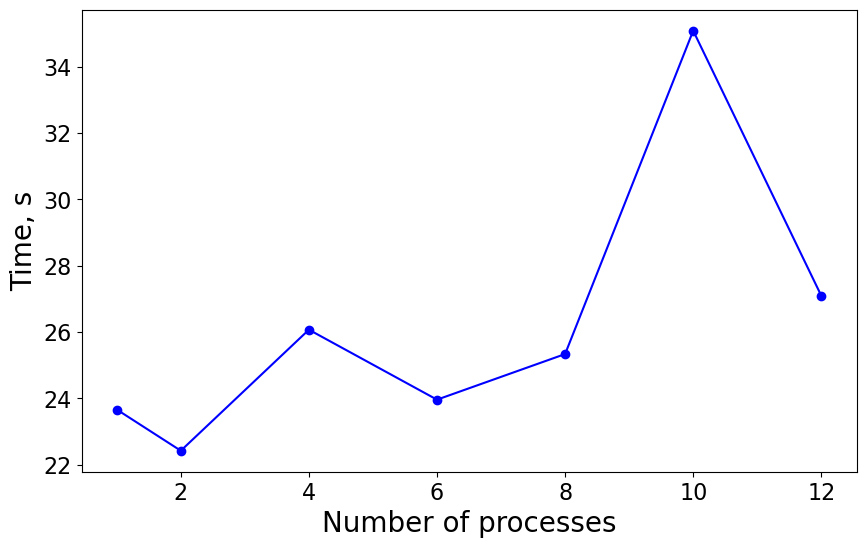

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(num_procs, enthropy_time, marker='o', color='blue')
plt.xlabel('Number of processes', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Time, s', fontsize=20)
plt.yticks(fontsize=16)
plt.show()

### Task 2: Enthalpy | Numba

![](Project_images/Enthalpy_equation.png)

#### Values

In [13]:
omega_min, omega_max = 1, 1000
T=273
array_size = np.arange(10**6, 10**7+1, 10**6)

#### Regular & Numba Implementation

In [55]:
enthalpy_time = np.zeros(len(array_size))
paral_enthalpy_time = np.zeros(len(array_size))
for i, N in enumerate(array_size):
    enthalpy_time[i] = timeit.timeit(lambda: custom_f.trapezoidal_function(
    f=custom_f.enthalpy,
    xmin=omega_min,
    xmax=omega_max,
    n=N,
    T=T,
    kb=kB,
    hbar=hbar
    ), number=1)

    paral_enthalpy_time[i] = timeit.timeit(lambda: custom_f.trapezoidal_function(
        f=custom_f.jit_enthalpy,
        xmin=omega_min,
        xmax=omega_max,
        n=N,
        T=T,
        kb=kB,
        hbar=hbar,
    ), number=1)

with open("saved_data/enthalpy_time.pkl", "wb") as file:
    pickle.dump(enthalpy_time, file)

with open("saved_data/paral_enthalpy_time.pkl", "wb") as file:
    pickle.dump(paral_enthalpy_time, file)

#### Performance

In [7]:
fig = go.Figure()

fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = enthalpy_time,
                            name = 'Regular',
                            ))
fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = paral_enthalpy_time,
                            name = 'Numba',
                            ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Evaluation",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,
                    # X-axis
                    xaxis_title = f"Size of arrays, 10<sup>6</sup>",
                    #xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Computation time, s",
                    #yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,
                    yaxis_ticks = 'outside'
                    )

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'
fig.write_image(file="Project_images/Enthalpy_evaluation.png",
                format='png',
                width=1400,
                height=700,
                scale=1
                )
#fig.show()

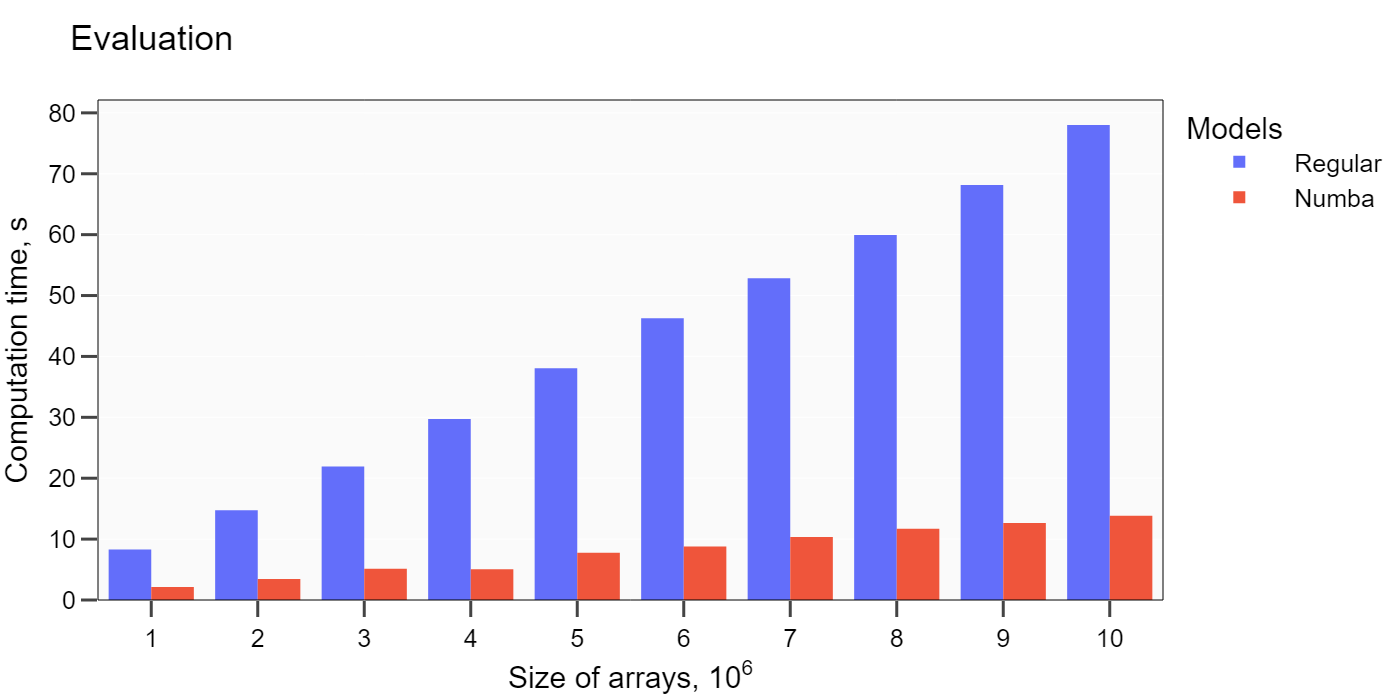

In [8]:
Image(open("Project_images/Enthalpy_evaluation.png", 'rb').read())


### Task 3: Gibbs Energy | MPI

![](Project_images/GibbsEnergy_equation.png)

#### Values

In [12]:
omega_min, omega_max = 1, 1000
n = 100000
T=100
tmin, tmax, step = 100, 1001, 5
step_array = np.arange(5, 51, 5)

#### Regular Implementation

In [58]:
gibbsEnergy_time = np.zeros_like(step_array)
for i, step in enumerate(step_array):
    temp_range = np.arange(tmin, tmax, step)
    #gibbs_energy = np.zeros_like(temp_range, dtype=np.float64)

    start_time = time.time()
    for j, T in enumerate(temp_range):
        entropy_value = - T * kB * custom_f.trapezoidal_function(
            f=custom_f.jit_entropy,
            xmin=omega_min,
            xmax=omega_max,
            n=n,
            T=T,
            kb=kB,
            hbar=hbar)

        enthalpy_value = custom_f.trapezoidal_function(
            f=custom_f.jit_enthalpy,
            xmin=omega_min,
            xmax=omega_max,
            n=n,
            T=T,
            kb=kB,
            hbar=hbar
            )
    end_time = time.time()
    gibbsEnergy_time[i] = end_time - start_time
    #gibbs_energy[j] = enthalpy_value + entropy_value

with open("saved_data/gibbsEnergy_time.pkl", "wb") as file:
    pickle.dump(gibbsEnergy_time, file)

#### MPI Implementation

In [45]:
%%writefile saved_files/parallel_gibbs_energy.py

# Import Library
from mpi4py import MPI
import numpy as np
import argparse
import custom_functions as custom_f

# Constants
hbar = 1.054e-34
kB = 1.38e-23

# Parser
parser = argparse.ArgumentParser()
parser.add_argument('--tmin', type=int, help='Lower bound of the temperature')
parser.add_argument('--tmax', type=int, help='Upper bound of the temperature')
parser.add_argument('--step', type=int, help='Temperature step')
parser.add_argument('--xmin', type=float, help='Lower bound of the integral')
parser.add_argument('--xmax', type=float, help='Upper bound of the integral')
parser.add_argument('--n', type=int, help='Number of points in the integral')
args = parser.parse_args()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

temp_range = np.arange(args.tmin, args.tmax, args.step)
local_values = np.zeros_like(temp_range, dtype=np.float64)
global_values = None
if rank == 0:
    global_values = np.zeros_like(temp_range, dtype=np.float64)

# Main Calculations
for i, T in enumerate(temp_range):
    if rank == 0:
        local_values[i] = - T * kB * custom_f.trapezoidal_function(
            f=custom_f.jit_entropy,
            xmin=args.xmin,
            xmax=args.xmax,
            n=args.n,
            T=T,
            kb=kB,
            hbar=hbar)
    else:
        local_values[i] = custom_f.trapezoidal_function(
            f=custom_f.jit_enthalpy,
            xmin=args.xmin,
            xmax=args.xmax,
            n=args.n,
            T=T,
            kb=kB,
            hbar=hbar
            )

comm.Reduce(local_values, global_values, op=MPI.SUM, root=0)

# Output results
# if rank == 0:
#     print(f"Gibbs Free Energy: {global_values}")

Writing saved_files/parallel_gibbs_energy.py


In [61]:
paral_gibbsEnergy_time = np.zeros_like(step_array)
for i, step in enumerate(step_array):
    start_time = time.time()
    os.system(f'mpiexec -n 2 python saved_files/parallel_gibbs_energy.py --tmin={tmin} --tmax={tmax} --step={step} --xmax={omega_max} --xmin={omega_min} --n={n}')
    end_time = time.time()
    paral_gibbsEnergy_time[i] = end_time - start_time

with open("saved_data/paral_gibbsEnergy_time.pkl", "wb") as file:
    pickle.dump(paral_gibbsEnergy_time, file)

#### Performance

In [18]:
fig = go.Figure()

fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, step_array)),
                            y = gibbsEnergy_time,
                            name = 'Regular',
                            ))
fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, step_array)),
                            y = paral_gibbsEnergy_time,
                            name = 'MPI',
                            ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Evaluation",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,
                    # X-axis
                    xaxis_title = f"Step",
                    #xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Computation time, s",
                    #yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,
                    yaxis_ticks = 'outside'
                    )

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'
fig.write_image(file="Project_images/GibbsEnergy_evaluation.png",
                format='png',
                width=1400,
                height=700,
                scale=1
                )
#fig.show()

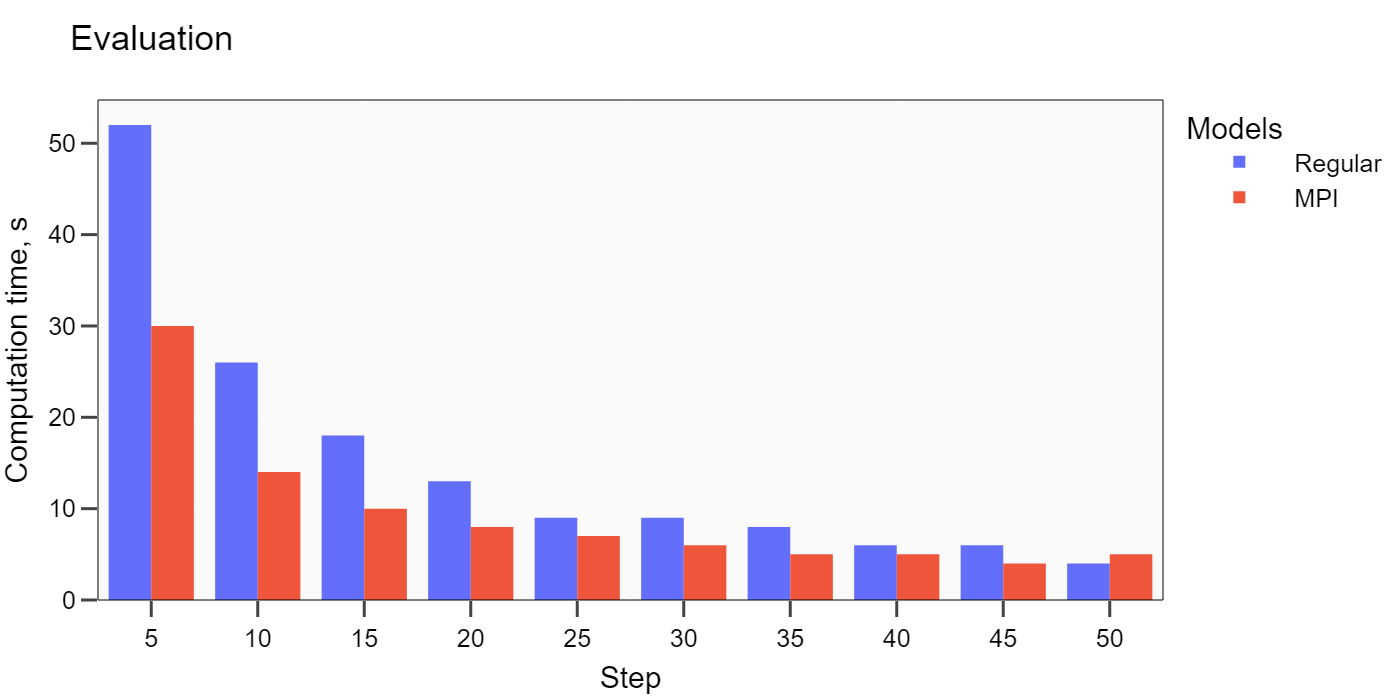

In [19]:
Image(open("Project_images/GibbsEnergy_evaluation.png", 'rb').read())

### Task 4: Helmholtz Free Energy | GPU

![](Project_images/Helmholtz_equation.png)

#### Values

In [21]:
omega_min, omega_max = 1, 1000
n = 10**8
T=100
array_size = np.arange(10**7, 10**8+1, 10**7)
helmEnergy_time = np.zeros_like(array_size)
paral_helmEnergy_time = np.zeros_like(array_size)
gpu_speed_calc = np.zeros_like(array_size)

#### Functions

In [64]:
def gpu_helmholtz_energy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return cp.log(2 * cp.sinh(x / 2)) * 1 * omega**2 * cp.exp(-omega / 10)

def gpu_trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)
    x = cp.linspace(xmin, xmax, n)
    integral = dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2
    return integral.sum()

#### CPU & GPU Implementation

In [65]:
for i, n in enumerate(array_size):
  start_time = time.perf_counter()
  custom_f.cpu_trapezoidal_function(
      f=custom_f.helmholtz_energy,
      xmin=omega_min,
      xmax=omega_max,
      n=n,
      T=T,
      kb=kB,
      hbar=hbar
  )
  end_time = time.perf_counter()
  helmEnergy_time[i] = (end_time - start_time)*1000000


  start_time = time.perf_counter()
  gpu_trapezoidal_function(
      f=gpu_helmholtz_energy,
      xmin=omega_min,
      xmax=omega_max,
      n=n,
      T=T,
      kb=kB,
      hbar=hbar
  )
  end_time = time.perf_counter()
  paral_helmEnergy_time[i] = (end_time - start_time)*1000000

  gpu_speed_calc[i] = helmEnergy_time[i] / paral_helmEnergy_time[i]


with open("saved_data/gpu_speed_calc.pkl", "wb") as file:
    pickle.dump(gpu_speed_calc, file)

with open("saved_data/helmEnergy_time.pkl", "wb") as file:
    pickle.dump(helmEnergy_time, file)

with open("saved_data/paral_helmEnergy_time.pkl", "wb") as file:
    pickle.dump(paral_helmEnergy_time, file)

#### Performance

In [34]:
fig = go.Figure()

fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = gpu_speed_calc,
                            name = 'CPU|Numpy',
                            ))
# fig.add_trace(go.Histogram(histfunc= 'max',
#                             x = list(map(str, np.arange(1, 11, 1))),
#                             y = paral_helmEnergy_time,
#                             name = 'GPU|CuPy',
#                             ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Speed CuPy / NumPy",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,
                    # X-axis
                    xaxis_title = f"Size of arrays, 10<sup>7</sup>",
                    #xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Performance",
                    #yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,
                    yaxis_ticks = 'outside'
                    )

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'
fig.write_image(file="Project_images/HelmEnergy_evaluation.png",
                format='png',
                width=1400,
                height=700,
                scale=1
                )
#fig.show()

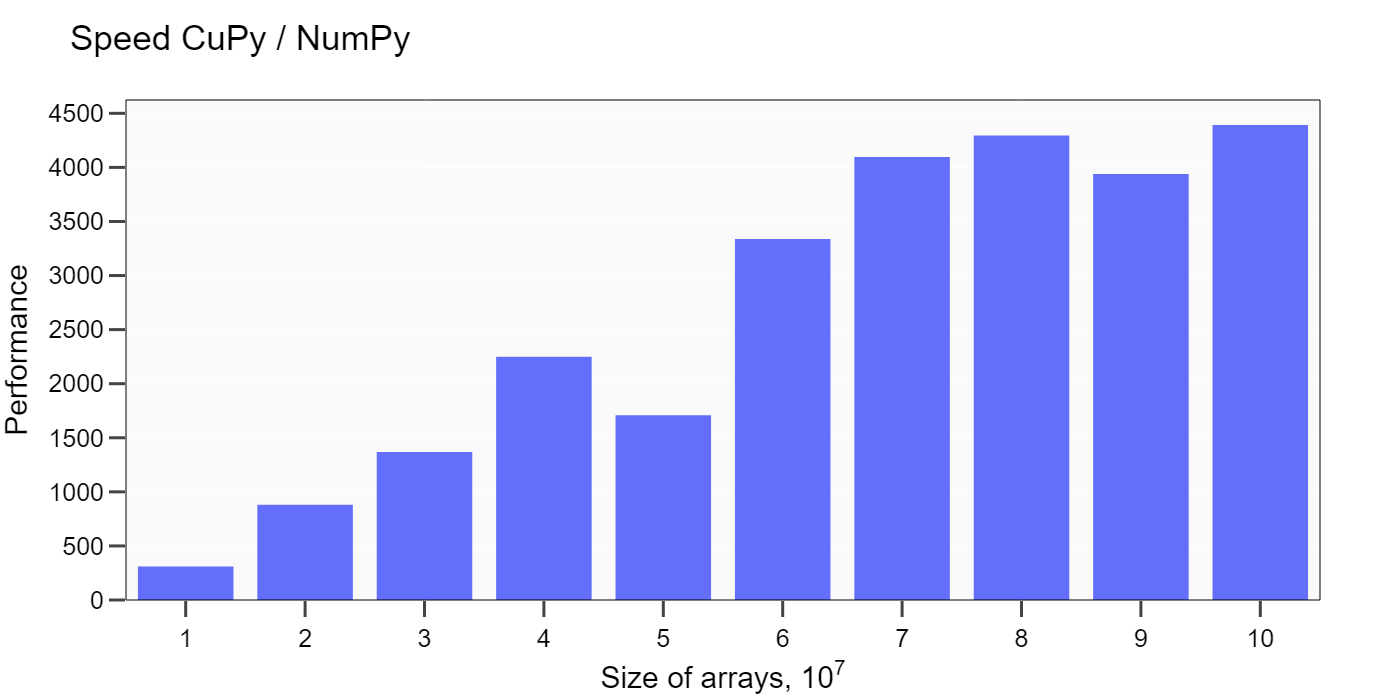

In [35]:
Image(open("Project_images/HelmEnergy_evaluation.png", 'rb').read())